In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [2]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []


In [3]:
for directory_path in glob.glob("images/original_images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("images/masked_images"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 


In [4]:
#https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

In [5]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

2024-08-12 23:22:31.686551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:22:31.695280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:22:31.695573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:22:31.697449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [8]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

#Plot features to view them
square = 4
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()


2024-08-12 23:22:33.606386: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-08-12 23:22:34.911580: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


7/8 [=========================>....] - ETA: 0s

2024-08-12 23:22:36.689764: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 725.51MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


8/8 [==============================] - 4s 277ms/step


2024-08-12 23:22:36.996961: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 808.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-12 23:22:37.103412: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 592.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-12 23:22:47.219145: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 984.00MiB (rounded to 1031798784)requested by op ConcatV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current 

ResourceExhaustedError: OOM when allocating tensor with shape[246,128,128,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [ ]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())


In [11]:
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
#dataset = dataset[dataset['Label'] != 0]

In [12]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

In [40]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 40, random_state = 42)


In [17]:
# ! pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com --no-cache-dir

In [20]:
# ! pip install cugraph-cu11 --extra-index-url=https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... -^C
anceled
ERROR: Operation cancelled by user


In [16]:
from cuml import RandomForestClassifier as cuRF
# cuml Random Forest params
cu_rf_params = {'n_estimators': 25, 'random_state':42}
cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_for_RF, Y_for_RF)

UnsupportedCUDAError: A GPU with NVIDIA Volta™ (Compute Capability 7.0) or newer architecture is required.
Detected GPU 0: NVIDIA GeForce 940M                                                                                                                                                                                                                                             
Detected Compute Capability: 5.0

In [ ]:
print("cuml RF Accuracy Score: " accuracy_score(cu_rf.predict(X_test), y_test))

In [ ]:
# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

#############################################

In [20]:
#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [21]:
#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

In [23]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('test_images/A4.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

In [24]:
#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

1/1 [==============================] - 0s 33ms/step


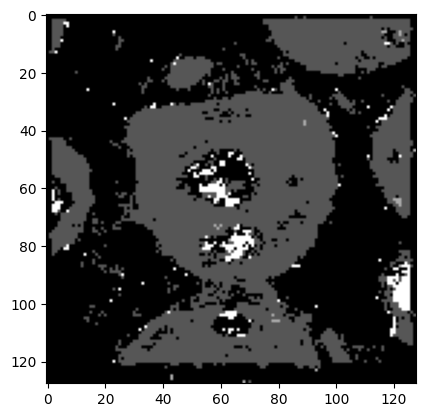

In [25]:
##View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.show()

In [ ]:
plt.imsave('test_images/A4_predicted_RF.png', prediction_image, cmap='gray')

In [27]:
truth.shape

(272896,)

In [29]:
prediction_image.shape

(128, 128)

In [26]:
truth = cv2.imread('test_masks/A4.png', 0).reshape(-1)

##########################################
#Pixel accuracy - not a good metric for semantic segmentation
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(truth, prediction))

ValueError: Found input variables with inconsistent numbers of samples: [272896, 16384]

1/1 [==============================] - 1s 565ms/step


ValueError: Found input variables with inconsistent numbers of samples: [272896, 16384]

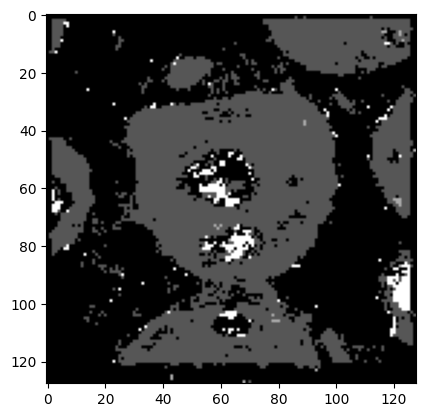

In [22]:









##############################################

#IOU for each class is..
# IOU = true_positive / (true_positive + false_positive + false_negative).

#Using built in keras function
from keras.metrics import MeanIoU
num_classes = 4
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(truth, prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(num_classes, num_classes)
print(values)

#Please verify the following code for correctness of IoU calculation
#I may have made some mistake in assigning the right values. 
class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[2,1]+ values[3,1]+ values[4,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[2,3] + values[2,4] + values[1,2]+ values[3,2]+ values[4,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,1] + values[3,2] + values[3,4] + values[1,3]+ values[2,3]+ values[4,3])
class4_IoU = values[4,4]/(values[4,4] + values[4,1] + values[4,2] + values[4,3] + values[1,4]+ values[2,4]+ values[3,4])
print("IoU Class 1 =", class1_IoU)
print("IoU Class 2 =", class2_IoU)
print("IoU Class 3 =", class3_IoU)
print("IoU Class 4 =", class4_IoU)
# Change hyperparameters to fine tune the model and verify IoU.